In [1]:
import glob
import pandas as pd

In [14]:
files_hq = glob.glob("./train_hq/train_hq/*")
files_mask = glob.glob("./train_masks/train_masks/*")
files_hq = ["./ipyfiles/u-net" +i.replace("\\","/").strip(".") for i in files_hq]
files_mask = ["./ipyfiles/u-net" +i.replace("\\","/").strip(".") for i in files_mask]
dicta = {"Image":files_hq,
         "label":files_mask}
df = pd.DataFrame(dicta)
df.to_csv("Unet_train.csv",index=False)

In [15]:
df

,Image,label
0,./ipyfiles/u-net/train_hq/train_hq/00087a6bd4d...,./ipyfiles/u-net/train_masks/train_masks/00087...
1,./ipyfiles/u-net/train_hq/train_hq/00087a6bd4d...,./ipyfiles/u-net/train_masks/train_masks/00087...
2,./ipyfiles/u-net/train_hq/train_hq/00087a6bd4d...,./ipyfiles/u-net/train_masks/train_masks/00087...
3,./ipyfiles/u-net/train_hq/train_hq/00087a6bd4d...,./ipyfiles/u-net/train_masks/train_masks/00087...
4,./ipyfiles/u-net/train_hq/train_hq/00087a6bd4d...,./ipyfiles/u-net/train_masks/train_masks/00087...
...,...,...
5083,./ipyfiles/u-net/train_hq/train_hq/fff9b3a5373...,./ipyfiles/u-net/train_masks/train_masks/fff9b...
5084,./ipyfiles/u-net/train_hq/train_hq/fff9b3a5373...,./ipyfiles/u-net/train_masks/train_masks/fff9b...
5085,./ipyfiles/u-net/train_hq/train_hq/fff9b3a5373...,./ipyfiles/u-net/train_masks/train_masks/fff9b...
5086,./ipyfiles/u-net/train_hq/train_hq/fff9b3a5373...,./ipyfiles/u-net/train_masks/train_masks/fff9b...


In [1]:
from torchvision.io import read_image
img = (read_image("./train_hq/train_hq/00087a6bd4dc_01.jpg"))

In [2]:
import matplotlib.pyplot as plt


In [3]:
from dataset import CustomUnetDataset
from torch.utils.data import DataLoader
from torchvision import datasets
import torch
import matplotlib.pyplot as plt

In [3]:
train = CustomUnetDataset("Unet_train.csv",train=True)
eval = CustomUnetDataset("Unet_train.csv",train=False)
train_set = DataLoader(train,batch_size=1,shuffle=True)
eval_set = DataLoader(eval,batch_size=1,shuffle=True)


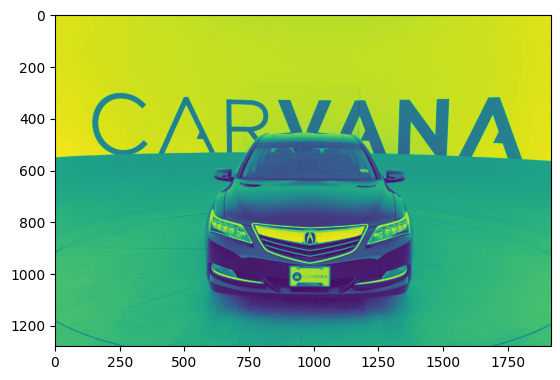

In [9]:
plt.imshow(img[0])

In [11]:
model = torch.load("./trained/checkpoint-6",weights_only=True)

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.Unet was not an allowed global by default. Please use `torch.serialization.add_safe_globals([Unet])` to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [20]:
import torch.nn as nn
import torch.nn.functional as f
import torchvision.transforms as transforms
class UpSample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)

    def forward(self, x1):
        x1 = self.up(x1)
        return x1
class Unet(nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.downsample1 = nn.Sequential(
                        nn.Conv2d(3,64,kernel_size=3,padding=1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(64,64,kernel_size=3,padding=1)
                        ,nn.ReLU(inplace=True),
            
        )
        self.downsample2 = nn.Sequential(
                        nn.Conv2d(64,128,kernel_size=3,padding=1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(128,128,kernel_size=3,padding=1)
                        ,nn.ReLU(inplace=True),
            
        )
        self.downsample3 = nn.Sequential(
                        nn.Conv2d(128,256,kernel_size=3,padding=1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(256,256,kernel_size=3,padding=1)
                        ,nn.ReLU(inplace=True),
            
        )
        self.downsample4 = nn.Sequential(
                        nn.Conv2d(256,512,kernel_size=3,padding=1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(512,512,kernel_size=3,padding=1)
                        ,nn.ReLU(inplace=True),
            
        )
        
        ### to make it equivalent
        self.bottom = nn.Sequential(
                        nn.Conv2d(512,1024,kernel_size=3,padding=1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(1024,1024,kernel_size=3,padding=1)
                        ,nn.ReLU(inplace=True),
            
        )
        self.upsampling4 = nn.Sequential(
                        nn.Conv2d(1024,512,kernel_size=3,padding=1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(512,512,kernel_size=3,padding=1)
                        ,nn.ReLU(inplace=True),
        )
        
        self.upsampling3 = nn.Sequential(
                        nn.Conv2d(512,256,kernel_size=3,padding=1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(256,256,kernel_size=3,padding=1)
                        ,nn.ReLU(inplace=True),
        )
        self.upsampling2 = nn.Sequential(
                        nn.Conv2d(256,128,kernel_size=3,padding=1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(128,128,kernel_size=3,padding=1)
                        ,nn.ReLU(inplace=True),
        )
        self.upsampling1 = nn.Sequential(
                        nn.Conv2d(128,64,kernel_size=3,padding=1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(64,64,kernel_size=3,padding=1)
                        ,nn.ReLU(inplace=True),
        )
        self.last = nn.Sequential(nn.Conv2d(64,3,kernel_size=1))
        self.up1  = UpSample(1024)
        self.up2  = UpSample(512)
        self.up3  = UpSample(256)
        self.up4  = UpSample(128)
    def forward(self,x):
        
        x1 = self.downsample1(x)
        x1m = self.maxpool(x1)
        
        x2 = self.downsample2(x1m)
        x2m = self.maxpool(x2)
        
        x3 = self.downsample3(x2m)
        x3m = self.maxpool(x3)
        
        x4 = self.downsample4(x3m)
        x4m = self.maxpool(x4)
        
        b = self.bottom(x4m)
        
        y1 = self.up1(b)
        y1 = torch.cat([x4,y1],dim=1)
        y2 = self.upsampling4(y1)
        
        y2 = self.up2(y2)
        y2 = torch.cat([x3,y2],dim=1)
        y3 = self.upsampling3(y2)
        
        
        y3 =  self.up3(y3)
        y3 = torch.cat([x2,y3],dim=1)
        y4 = self.upsampling2(y3)
        
        y4 =  self.up4(y4)
        
        y4 = torch.cat([x1,y4],dim=1)
        y5 = self.upsampling1(y4)
        
        y = self.last(y5)
        
        return y


In [21]:
dicta = torch.load("./trained/checkpoint-1")

C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_25792\90691855.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dicta = torch.load("./trained/checkpoint-1")


In [22]:
img.size()

torch.Size([3, 224, 224])

In [23]:
model = Unet()
model.load_state_dict(dicta)
model.to("cuda")

Unet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (downsample1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (downsample2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (downsample3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (downsample4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), str

In [8]:
resize_transform = transforms.Resize((224, 224))
image = resize_transform(img)

In [11]:
img = image/255

In [17]:
img.size()

torch.Size([3, 224, 224])

In [24]:
abc = model(img.to("cuda"))

torch.Size([512, 56, 28])


RuntimeError: Given groups=1, weight of size [512, 1024, 3, 3], expected input[1, 512, 56, 28] to have 1024 channels, but got 512 channels instead